Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler


Load the dataset


In [35]:
# Load the Excel file
file_path = './data/883eax2-sup-0002.xlsx'
df = pd.read_excel(file_path)

Exploration of the data

Dataset shape: (4758, 38)
Column types:
 Winter_mortality          int64
Age                       int64
Activity                 object
Beekeep_for               int64
Qualif                    int64
Training                  int64
Coop_treat                int64
Bee_population_size       int64
Country                  object
Apiary_Size               int64
Production               object
Apiarist_book             int64
Org_member                int64
Continue                  int64
Breed                    object
Chronic_Depop             int64
ClinSign_Brood            int64
ClinSign_Honeybees        int64
H_Rate_ColMortality       int64
H_Rate_HoneyMortality     int64
OtherEvent                int64
VarroaMites               int64
QueenProblems             int64
Management               object
Swarm_bought              int64
Swarm_produced            int64
Queen_bought              int64
Queen_produced            int64
MidSeason_Target         object
Environment              object

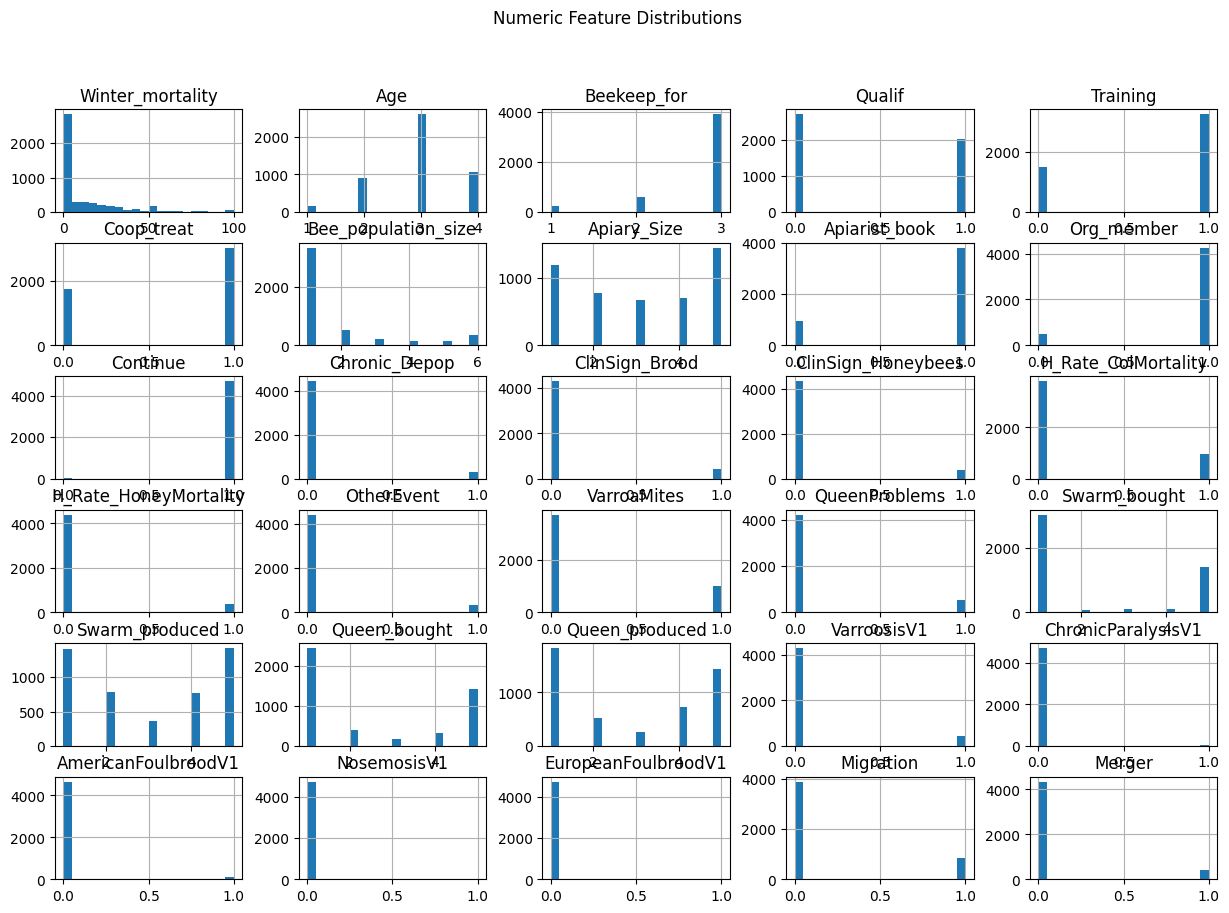

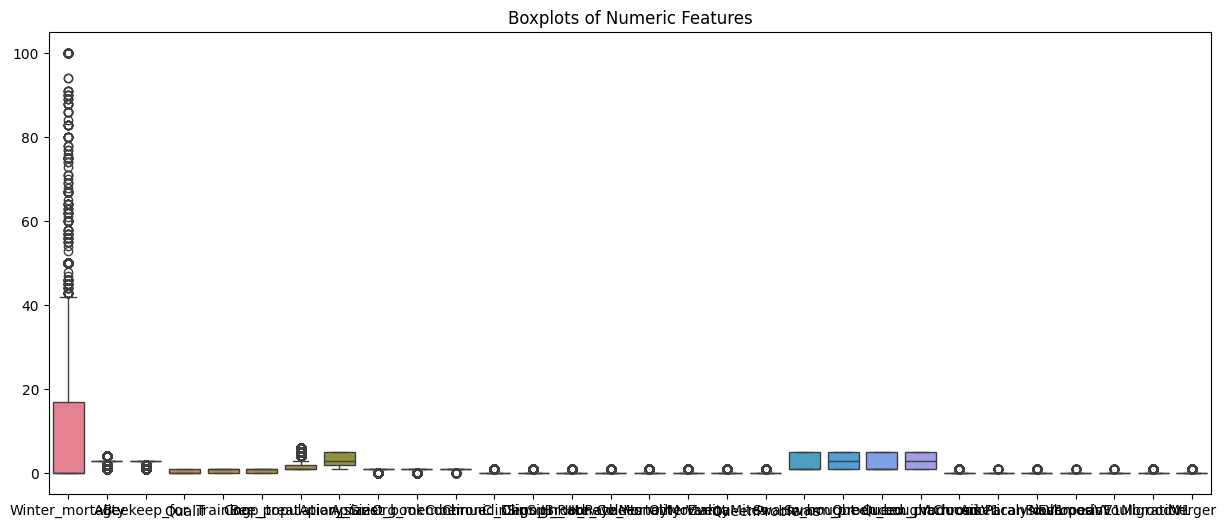

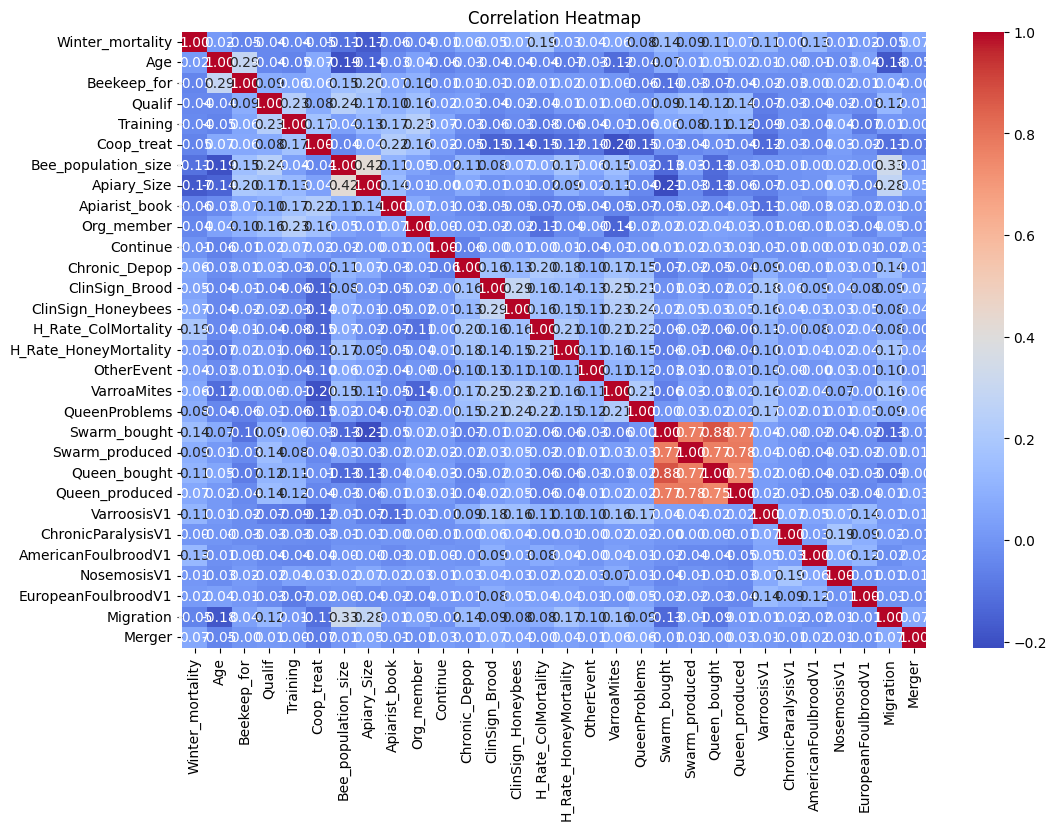


Column: Activity
Activity
Hobby           3079
Professional     860
Part_time        819
Name: count, dtype: int64

Column: Country
Country
FRANCE       470
SLOVAKIA     363
SPAIN        361
ESTONIA      355
GERMANY      355
POLAND       353
HUNGARY      347
FINLAND      291
LITHUANIA    280
BELGIUM      274
Name: count, dtype: int64

Column: Production
Production
01__Only Honey                         3712
02__Includes pollen production          305
06__Includes swarm production           284
07__Other                               272
04__Includes queens production          100
03__Includes pollination services        65
05__Includes royal jelly production      20
Name: count, dtype: int64

Column: Breed
Breed
A. m. carnica       1821
Hybrid               643
Buckfast             599
Local bees           578
A. m. ligustica      505
A. m. mellifera      386
A. m. iberiensis     140
A. m. ccm             86
Name: count, dtype: int64

Column: Management
Management
Livestock           

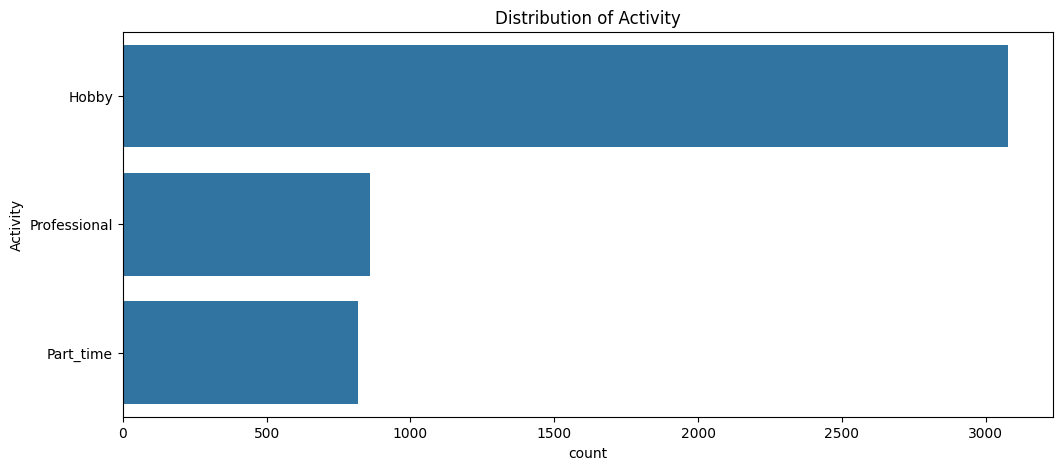

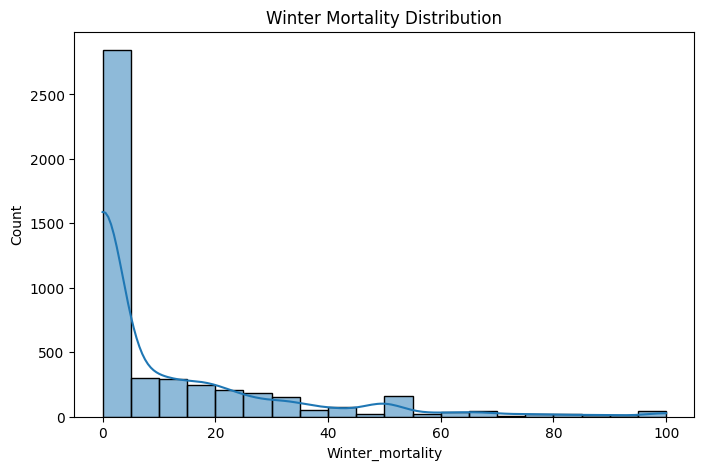

In [46]:
# 1. Basic info
print("Dataset shape:", df.shape)
print("Column types:\n", df.dtypes)
print("First 5 rows:\n", df.head())
# 2. Summary statistics
summary_stats = df.describe(include='all')  # include='all' for non-numeric too
print("Summary statistics:\n", summary_stats)

# 3. Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# 4. Correlation matrix for numeric variables
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()
print("Correlation matrix:\n", corr_matrix)

# 5. Visualizations
# Histogram for distributions
df[numeric_cols].hist(figsize=(15,10), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(15,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots of Numeric Features")
plt.show()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Categorical columns
cat_cols = df.select_dtypes(include='object').columns

# Frequency counts for categorical columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts().head(10))  # top 10 categories

# Bar plots for some categorical features
plt.figure(figsize=(12,5))
sns.countplot(y='Activity', data=df, order=df['Activity'].value_counts().index)
plt.title('Distribution of Activity')
plt.show()

# Distribution of target
plt.figure(figsize=(8,5))
sns.histplot(df['Winter_mortality'], bins=20, kde=True)
plt.title('Winter Mortality Distribution')
plt.show()

## Data preprocessing

Figuring out col types first

In [36]:
num_like_cols = ['Age', 'Beekeep_for', 'Bee_population_size', 'Apiary_Size',
                 'Swarm_bought', 'Swarm_produced', 'Queen_bought', 'Queen_produced']
binary_cols = ['Qualif','Training','Coop_treat','Apiarist_book','Org_member','Continue',
               'Chronic_Depop','ClinSign_Brood','ClinSign_Honeybees','H_Rate_ColMortality',
               'H_Rate_HoneyMortality','OtherEvent','VarroaMites','QueenProblems',
               'VarroosisV1','ChronicParalysisV1','AmericanFoulbroodV1','NosemosisV1',
               'EuropeanFoulbroodV1','Migration','Merger']
categorical_cols = ['Activity','Country','Production','Breed','Management',
                    'MidSeason_Target','Environment','Program']

dropping unnecessary column

In [37]:
df = df.drop(columns=['ID_api'])

In [38]:
# 2. Handle missing values
df['Environment'] = df['Environment'].fillna(df['Environment'].mode()[0])

# check if remaining missing values are left
print("remaining missing values", df.isnull().sum())


# we are trying to extract the numeric part before any delimiters
for col in num_like_cols:
    df[col] = df[col].apply(lambda x: int(str(x).split('___')[0].split('__')[0])) # example: "1___Less than 30" becomes 1

# go from strings to binary 0/1
for col in binary_cols:
    df[col] = df[col].map({'Yes':1,'No':0,'Suffering':1,'Not_Suffering':0})


# Quick look at transformed columns
df[num_like_cols + binary_cols].head(10)
for col in num_like_cols + binary_cols:
    print(col, df[col].unique())

print(df[num_like_cols + binary_cols].isnull().sum())

df[num_like_cols].describe()



remaining missing values Winter_mortality         0
Age                      0
Activity                 0
Beekeep_for              0
Qualif                   0
Training                 0
Coop_treat               0
Bee_population_size      0
Country                  0
Apiary_Size              0
Production               0
Apiarist_book            0
Org_member               0
Continue                 0
Breed                    0
Chronic_Depop            0
ClinSign_Brood           0
ClinSign_Honeybees       0
H_Rate_ColMortality      0
H_Rate_HoneyMortality    0
OtherEvent               0
VarroaMites              0
QueenProblems            0
Management               0
Swarm_bought             0
Swarm_produced           0
Queen_bought             0
Queen_produced           0
MidSeason_Target         0
Environment              0
VarroosisV1              0
ChronicParalysisV1       0
AmericanFoulbroodV1      0
NosemosisV1              0
EuropeanFoulbroodV1      0
Migration                0
Mer

,Age,Beekeep_for,Bee_population_size,Apiary_Size,Swarm_bought,Swarm_produced,Queen_bought,Queen_produced
count,4758.000000,4758.000000,4758.000000,4758.000000,4758.000000,4758.000000,4758.000000,4758.000000
mean,2.960277,2.770071,1.798235,3.092896,2.325557,3.002102,2.552963,2.872846
std,0.746021,0.528056,1.519705,1.582895,1.827471,1.647644,1.791423,1.727133
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,3.000000
75%,3.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,4.000000,3.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# Split/train

Get numeric_cols

In [39]:
numeric_cols = [col for col in df.columns if col not in categorical_cols + ['Winter_mortality']]
print("Numeric columns:", numeric_cols)

Numeric columns: ['Age', 'Beekeep_for', 'Qualif', 'Training', 'Coop_treat', 'Bee_population_size', 'Apiary_Size', 'Apiarist_book', 'Org_member', 'Continue', 'Chronic_Depop', 'ClinSign_Brood', 'ClinSign_Honeybees', 'H_Rate_ColMortality', 'H_Rate_HoneyMortality', 'OtherEvent', 'VarroaMites', 'QueenProblems', 'Swarm_bought', 'Swarm_produced', 'Queen_bought', 'Queen_produced', 'VarroosisV1', 'ChronicParalysisV1', 'AmericanFoulbroodV1', 'NosemosisV1', 'EuropeanFoulbroodV1', 'Migration', 'Merger']


In [47]:

numeric_cols = [col for col in df.columns if col not in categorical_cols + ['Winter_mortality']]
print("Numeric columns:", numeric_cols)


# 6. Split data into features and target
X = df.drop(columns=['Winter_mortality'])
y = df['Winter_mortality']

# 7. Train/Validation/Test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# normalize and get rid of extreme values for target
lower_bound = y_train.quantile(0.01)
upper_bound = y_train.quantile(0.90)   # skewed toward left tail so we use 90th percentile

y_train_clipped = y_train.clip(lower=lower_bound, upper=upper_bound)
y_val_clipped = y_val.clip(lower=lower_bound, upper=upper_bound)
y_test_clipped = y_test.clip(lower=lower_bound, upper=upper_bound)

# Normalize target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clipped.values.reshape(-1,1))
y_val_scaled = scaler_y.transform(y_val_clipped.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_clipped.values.reshape(-1,1))


ordinal_cols = ['Age','Beekeep_for','Bee_population_size','Apiary_Size',
                'Swarm_bought','Swarm_produced','Queen_bought','Queen_produced']
categorical_cols = ['Activity','Country','Production','Breed','Management',
                    'MidSeason_Target','Environment','Program']



# Numeric/ordinal pipeline: impute missing values with mean, then scale
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ColumnTransformer with pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, ordinal_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')  # binary columns remain unchanged

# Apply transformation
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)



Numeric columns: ['Age', 'Beekeep_for', 'Qualif', 'Training', 'Coop_treat', 'Bee_population_size', 'Apiary_Size', 'Apiarist_book', 'Org_member', 'Continue', 'Chronic_Depop', 'ClinSign_Brood', 'ClinSign_Honeybees', 'H_Rate_ColMortality', 'H_Rate_HoneyMortality', 'OtherEvent', 'VarroaMites', 'QueenProblems', 'Swarm_bought', 'Swarm_produced', 'Queen_bought', 'Queen_produced', 'VarroosisV1', 'ChronicParalysisV1', 'AmericanFoulbroodV1', 'NosemosisV1', 'EuropeanFoulbroodV1', 'Migration', 'Merger']


In [42]:
df.head()

,Winter_mortality,Age,Activity,Beekeep_for,Qualif,Training,Coop_treat,Bee_population_size,Country,Apiary_Size,...,MidSeason_Target,Environment,VarroosisV1,ChronicParalysisV1,AmericanFoulbroodV1,NosemosisV1,EuropeanFoulbroodV1,Migration,Merger,Program
0,29,4,Part_time,2,0,1,1,1,LATVIA,2,...,No Migration,Diverse,0,0,0,0,0,0,0,First Year
1,29,4,Hobby,3,0,1,1,1,LATVIA,3,...,No Migration,Diverse,0,0,0,0,0,0,0,First Year
2,0,1,Part_time,1,0,0,0,2,GREECE,5,...,No Migration,Farmland,1,0,0,0,0,0,0,First Year
3,0,4,Hobby,3,0,0,1,1,SLOVAKIA,1,...,No Migration,Diverse,0,0,0,0,0,0,0,First Year
4,50,4,Hobby,2,0,0,1,1,SLOVAKIA,1,...,No Migration,Wood,0,0,0,0,0,0,0,First Year


Save preprocessed data

In [48]:
np.save("X_train_processed.npy", X_train_processed)
np.save("X_val_processed.npy", X_val_processed)
np.save("X_test_processed.npy", X_test_processed)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

check if everything is still alright

In [49]:
for col in binary_cols:
    print(col, df[col].unique())

Qualif [0 1]
Training [1 0]
Coop_treat [1 0]
Apiarist_book [1 0]
Org_member [1 0]
Continue [1 0]
Chronic_Depop [0 1]
ClinSign_Brood [0 1]
ClinSign_Honeybees [0 1]
H_Rate_ColMortality [0 1]
H_Rate_HoneyMortality [0 1]
OtherEvent [0 1]
VarroaMites [1 0]
QueenProblems [0 1]
VarroosisV1 [0 1]
ChronicParalysisV1 [0 1]
AmericanFoulbroodV1 [0 1]
NosemosisV1 [0 1]
EuropeanFoulbroodV1 [0 1]
Migration [0 1]
Merger [0 1]


### Model training

In [50]:
# quick checks
print("NaNs in X_train:")
print(pd.DataFrame(X_train).isnull().sum())

print("NaNs in ordinal columns:")
print(X_train[ordinal_cols].isnull().sum())

print("NaNs in categorical columns:")
print(X_train[categorical_cols].isnull().sum())

print("NaNs in remaining columns (binary, passthrough):")
remaining_cols = [c for c in X_train.columns if c not in ordinal_cols + categorical_cols]
print(X_train[remaining_cols].isnull().sum())

# Helper function to evaluate
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # safe for any sklearn version
    print("RMSE:", rmse)
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R^2:", r2_score(y_true, y_pred))
    print("\n")

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
y_val_pred_lr = lr.predict(X_val_processed)
evaluate_model(y_val, y_val_pred_lr, "Linear Regression")

# 2. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train_processed, y_train)
y_val_pred_rf = rf.predict(X_val_processed)
evaluate_model(y_val, y_val_pred_rf, "Random Forest")

# 3. Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_processed, y_train)
y_val_pred_gb = gb.predict(X_val_processed)
evaluate_model(y_val, y_val_pred_gb, "Gradient Boosting")


with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr, f)


# Results
# --- Linear Regression ---
# RMSE: 18.747355794878878
# MAE: 12.670191530342345
# R^2: 0.1476944466416199


# --- Random Forest ---
# RMSE: 19.576388615537716
# MAE: 13.036145337483344
# R^2: 0.07064758839180507


# --- Gradient Boosting ---
# RMSE: 18.868034280775355
# MAE: 12.632342875715272
# R^2: 0.13668638894169238

NaNs in X_train:
Age                      0
Activity                 0
Beekeep_for              0
Qualif                   0
Training                 0
Coop_treat               0
Bee_population_size      0
Country                  0
Apiary_Size              0
Production               0
Apiarist_book            0
Org_member               0
Continue                 0
Breed                    0
Chronic_Depop            0
ClinSign_Brood           0
ClinSign_Honeybees       0
H_Rate_ColMortality      0
H_Rate_HoneyMortality    0
OtherEvent               0
VarroaMites              0
QueenProblems            0
Management               0
Swarm_bought             0
Swarm_produced           0
Queen_bought             0
Queen_produced           0
MidSeason_Target         0
Environment              0
VarroosisV1              0
ChronicParalysisV1       0
AmericanFoulbroodV1      0
NosemosisV1              0
EuropeanFoulbroodV1      0
Migration                0
Merger                   0
Program    

# Tuning

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring='neg_mean_squared_error',   # since we want low RMSE
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_processed, y_train)

print("Best RF parameters:", rf_grid.best_params_)
print("Best RF score (neg MSE):", rf_grid.best_score_)


gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5],
    'subsample': [0.7, 0.9, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=gb_params,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_processed, y_train)

print("Best GB parameters:", gb_grid.best_params_)
print("Best GB score (neg MSE):", gb_grid.best_score_)


# Random Forest tuned
rf_best = rf_grid.best_estimator_
rf_val_pred = rf_best.predict(X_val_processed)
evaluate_model(y_val, rf_val_pred, "Tuned Random Forest")

# Gradient Boosting tuned
gb_best = gb_grid.best_estimator_
gb_val_pred = gb_best.predict(X_val_processed)
evaluate_model(y_val, gb_val_pred, "Tuned Gradient Boosting")

# Save Random Forest
with open("rf_best_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

# Save Gradient Boosting
with open("gb_best_model.pkl", "wb") as f:
    pickle.dump(gb_best, f)
# Fitting 3 folds for each of 216 candidates, totalling 648 fits
# Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
# Best RF score (neg MSE): -334.0638319389099
# Fitting 3 folds for each of 324 candidates, totalling 972 fits
# Best GB parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
# Best GB score (neg MSE): -331.01559885219007
# --- Tuned Random Forest ---
# RMSE: 18.661424077849787
# MAE: 12.541636337983208
# R^2: 0.15548991670223877


# --- Tuned Gradient Boosting ---
# RMSE: 18.667019550230183
# MAE: 12.541718292453268
# R^2: 0.15498340216538942


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best RF score (neg MSE): -334.0638319389099
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best GB parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Best GB score (neg MSE): -331.01559885219007
--- Tuned Random Forest ---
RMSE: 18.661424077849787
MAE: 12.541636337983208
R^2: 0.15548991670223877


--- Tuned Gradient Boosting ---
RMSE: 18.667019550230183
MAE: 12.541718292453268
R^2: 0.15498340216538942




# Evaluation

In [52]:
# Final chosen model (Gradient Boosting)
gb_best = gb_grid.best_estimator_
y_test_pred = gb_best.predict(X_test_processed)

evaluate_model(y_test, y_test_pred, "Final Tuned Gradient Boosting (Test Set)")
# --- Final Tuned Gradient Boosting (Test Set) ---
# RMSE: 17.141968089635913
# MAE: 12.185823537424666
# R^2: 0.15733452302430928

--- Final Tuned Gradient Boosting (Test Set) ---
RMSE: 17.141968089635913
MAE: 12.185823537424666
R^2: 0.15733452302430928




# Final model and saving 

In [53]:
# Use the best hyperparameters you found
best_gb = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

# Combine train + val for final training

X_final_train = np.vstack([X_train_processed, X_val_processed])
y_final_train = np.hstack([y_train, y_val])

# Fit on full training data
best_gb.fit(X_final_train, y_final_train)


with open("best_model.pkl", "wb") as f:
    pickle.dump(best_gb, f)
